In [1]:
import os
import pandas as pd
from IPython.display import display

# list to summon all files
sampled_dfs = []

# Find the folder
base_dir = os.getcwd()

# Supervise all files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust loading, remove useless data
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")


                # sample max 300 rows, per. file
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f" added correctly: {csv_path} ({sample_size} rows)")

            except Exception as e:
                print(f" incorrect loading {csv_path}: {e}")

# Combine files to a shared dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n final dataset {len(df):,} rows from {len(sampled_dfs)} files.")
    display(df.head())
else:
    print("No file was found")

 added correctly: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/May/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/Oktober/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/November/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/January/T_ONTIME_REPOR

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


In [2]:
# --- Prepare data for Logistic Classification Model (Leakage-Free Version) ---
# This cell creates the delay target variable and time-based predictors that can be known before departure.

import numpy as np
import pandas as pd

# --- Convert HHMM → minutes since midnight ---
# This function transforms scheduled or actual departure times into total minutes since midnight.
def hhmm_to_minutes(x):
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        return min(h * 60 + m, 1439)  # cap at 23:59
    except:
        return np.nan

# --- Create minute-based columns for actual and scheduled departure times ---
if "DEP_TIME" in df.columns:
    df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# --- Calculate delay in minutes (only for creating the target variable) ---
# Note: This column will NOT be used as an input feature to prevent data leakage.
if {"DEP_TIME_MIN", "CRS_DEP_TIME_MIN"}.issubset(df.columns):
    df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

print("\n'DEP_DELAY_MIN' successfully calculated.")
display(df[["DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "DEP_DELAY_MIN"]].head())

# --- Create the binary target variable for logistic classification ---
# 1 = delayed more than 15 minutes, 0 = on time
df["DELAYED"] = (df["DEP_DELAY_MIN"] > 15).astype(int)

print("\nTarget variable 'DELAYED' created (1 = delayed, 0 = on time).")
display(df[["DEP_DELAY_MIN", "DELAYED"]].head())

# --- Create cyclic time features for departure time ---
# These encode the time of day in a circular format to capture daily patterns
# (e.g., 23:59 and 00:01 are close in time, not far apart).
if "CRS_DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    print("\nCyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
    display(df[["CRS_DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())




'DEP_DELAY_MIN' successfully calculated.


,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN
0,353.0,360,-7.0
1,816.0,818,-2.0
2,421.0,424,-3.0
3,1299.0,1247,52.0
4,1054.0,1062,-8.0



Target variable 'DELAYED' created (1 = delayed, 0 = on time).


,DEP_DELAY_MIN,DELAYED
0,-7.0,0
1,-2.0,0
2,-3.0,0
3,52.0,1
4,-8.0,0



Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,CRS_DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
0,360,1.000000,6.123234e-17
1,818,-0.414693,-9.099613e-01
2,424,0.961262,-2.756374e-01
3,1247,-0.746057,6.658817e-01
4,1062,-0.996917,-7.845910e-02


In [3]:
# --- Convert DEP_TIME_MIN into 15-minute bins (categorical) ---
df["DEP_TIME_BIN"] = pd.cut(
    df["DEP_TIME_MIN"],
    bins=range(0, 1441, 15),
    labels=[f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]
)

print("\n Sample of 15-minute bins:")
display(df[["DEP_TIME_MIN", "DEP_TIME_BIN"]].head())

# --- Select model features ---
selected_features = ["MONTH",         
    "DAY_OF_WEEK",  
    "DAY_OF_MONTH",
    "DISTANCE",       
    "ORIGIN",        
    "DEST", 
    "DEP_TIME_sin",   
    "DEP_TIME_cos",   
    "OP_CARRIER_FL_NUM"]

# --- Keep only relevant rows (drop NaN) ---
df_model = df[selected_features + ["DELAYED"]].dropna()

X = df_model[selected_features]
y = df_model["DELAYED"]

print(f"\n Final dataset ready for modeling: {len(X)} rows, {len(selected_features)} features.")
display(X.head())



Sample of 15-minute bins:


,DEP_TIME_MIN,DEP_TIME_BIN
0,353.0,05:45
1,816.0,13:30
2,421.0,07:00
3,1299.0,21:30
4,1054.0,17:30



Final dataset ready for modeling: 3600 rows, 9 features.


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,ORIGIN,DEST,DEP_TIME_sin,DEP_TIME_cos,OP_CARRIER_FL_NUM
0,12,3,18,954.0,LAX,SEA,1.000000,6.123234e-17,1293.0
1,12,5,13,177.0,ORD,IND,-0.414693,-9.099613e-01,3764.0
2,12,2,31,1874.0,SEA,IAH,0.961262,-2.756374e-01,1788.0
3,12,7,22,191.0,CLT,OAJ,-0.746057,6.658817e-01,5487.0
4,12,5,13,83.0,CSG,ATL,-0.996917,-7.845910e-02,5374.0


Fitting 5 folds for each of 8 candidates, totalling 40 fits

 Best hyperparameters found:
{'classifier__C': 0.01, 'classifier__penalty': 'l1'}

 Optimized Logistic Regression – Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.86      0.51      0.64       580
           1       0.25      0.66      0.36       140

    accuracy                           0.54       720
   macro avg       0.55      0.59      0.50       720
weighted avg       0.74      0.54      0.58       720

Optimized ROC-AUC: 0.616


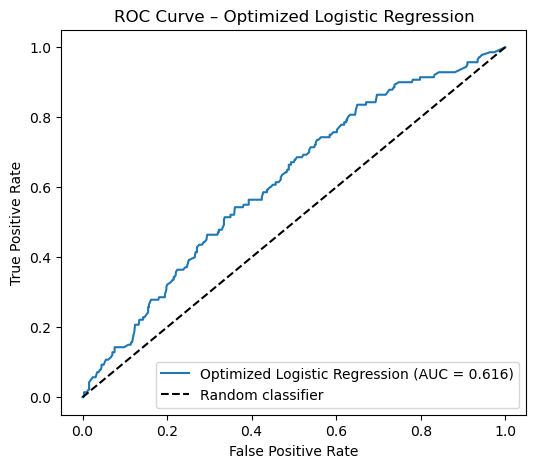


 Best decision threshold: 0.44999999999999996
 Best F1-score at optimized threshold: 0.361

 Final Optimized Model – Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.88      0.38      0.53       580
           1       0.23      0.79      0.36       140

    accuracy                           0.46       720
   macro avg       0.56      0.58      0.45       720
weighted avg       0.75      0.46      0.50       720



<Figure size 500x400 with 0 Axes>

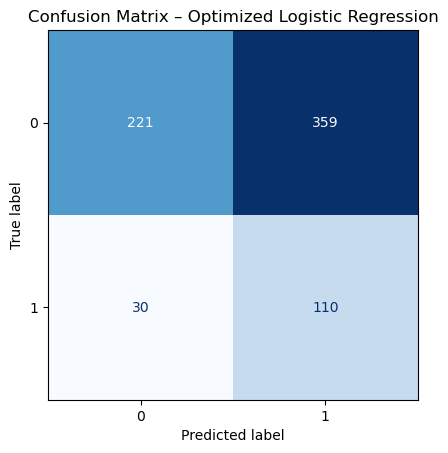

In [6]:
# 
# 🔧 MODEL OPTIMIZATION – LOGISTIC REGRESSION
# 
# This section optimizes the baseline Logistic Regression model.
#
# IMPORTANT:
# - L1 penalty  -> LASSO Logistic Regression
# - L2 penalty  -> RIDGE Logistic Regression
#
# GridSearchCV selects the best model based on cross-validated F1-score.
# 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

# 
# 1. DEFINE REGULARIZED LOGISTIC REGRESSION MODEL
# 
# 'liblinear' supports both L1 (Lasso) and L2 (Ridge)

log_reg_optimized = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    solver="liblinear"
)

optimized_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg_optimized)
    ]
)

# 
# 2. DEFINE HYPERPARAMETER GRID
# 
# penalty = "l1" -> LASSO Logistic Regression
# penalty = "l2" -> RIDGE Logistic Regression

param_grid = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.01, 0.1, 1, 10]
}

# 
# 3. GRID SEARCH WITH CROSS-VALIDATION
# 
# Optimize for F1-score due to class imbalance

grid_search = GridSearchCV(
    optimized_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n Best hyperparameters found:")
print(grid_search.best_params_)

# If penalty = 'l1' -> LASSO Logistic Regression
# If penalty = 'l2' -> RIDGE Logistic Regression
best_model = grid_search.best_estimator_

# 
# 4. EVALUATE OPTIMIZED MODEL (DEFAULT THRESHOLD = 0.5)
# 

y_pred_opt = best_model.predict(X_test)
y_pred_prob_opt = best_model.predict_proba(X_test)[:, 1]

print("\n Optimized Logistic Regression – Classification Report (threshold = 0.5):")
print(classification_report(y_test, y_pred_opt))

roc_auc_opt = roc_auc_score(y_test, y_pred_prob_opt)
print(f"Optimized ROC-AUC: {roc_auc_opt:.3f}")

# 
# 5. ROC CURVE – OPTIMIZED MODEL
# 
# The ROC curve evaluates how well the model separates
# delayed vs. non-delayed flights across all thresholds.

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_opt)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Optimized Logistic Regression (AUC = {roc_auc_opt:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Optimized Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# 
# 6. DECISION THRESHOLD OPTIMIZATION
# 
# Instead of using the default threshold (0.5),
# we select the threshold that maximizes F1-score.

thresholds = np.arange(0.2, 0.81, 0.05)
f1_scores = []

for t in thresholds:
    y_thresh_pred = (y_pred_prob_opt >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_thresh_pred))

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"\n Best decision threshold: {best_threshold}")
print(f" Best F1-score at optimized threshold: {best_f1:.3f}")

# 
# 7. FINAL EVALUATION WITH OPTIMIZED THRESHOLD
# 

y_final_pred = (y_pred_prob_opt >= best_threshold).astype(int)

print("\n Final Optimized Model – Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_final_pred))

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_final_pred)).plot(
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix – Optimized Logistic Regression")
plt.show()




Optimized Elastic Net Logistic Regression – Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       580
           1       0.25      0.59      0.36       140

    accuracy                           0.58       720
   macro avg       0.55      0.59      0.52       720
weighted avg       0.74      0.58      0.63       720

Optimized Elastic Net ROC-AUC: 0.635


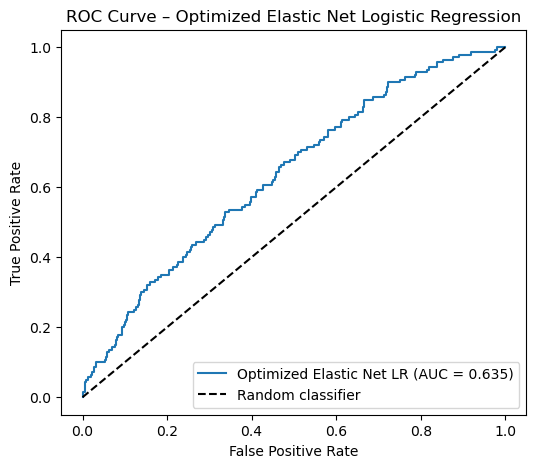

<Figure size 500x400 with 0 Axes>

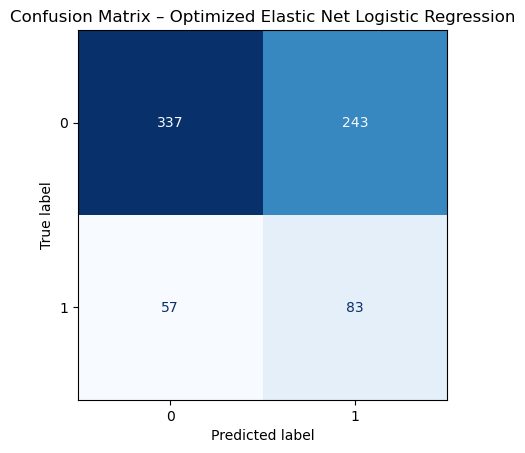

In [11]:
# 
# FINAL EVALUATION – OPTIMIZED ELASTIC NET LOGISTIC REGRESSION
# (Same evaluation setup as baseline)
# 

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# 
# 1. PREDICTIONS ON TEST SET
# 

y_pred_en = best_lr_en.predict(X_test)
y_pred_prob_en = best_lr_en.predict_proba(X_test)[:, 1]

# 
# 2. CLASSIFICATION REPORT (THRESHOLD = 0.5)
# 

print("\nOptimized Elastic Net Logistic Regression – Classification Report (threshold = 0.5):")
print(classification_report(y_test, y_pred_en))

# 
# 3. ROC-AUC
# 

roc_auc_en = roc_auc_score(y_test, y_pred_prob_en)
print(f"Optimized Elastic Net ROC-AUC: {roc_auc_en:.3f}")

# 
# 4. ROC CURVE (VISUAL)
# 

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_en)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Optimized Elastic Net LR (AUC = {roc_auc_en:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Optimized Elastic Net Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# 
# 5. CONFUSION MATRIX (SAME STYLE AS BASELINE)
# 

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_en)).plot(
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix – Optimized Elastic Net Logistic Regression")
plt.show()

